In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation

In [85]:
def theta(x):
    """
    theta function :
      returns 0 if x<=0, and 1 if x>0
    """
    x = np.asarray(x)
    y = np.zeros(x.shape)
    y[x > 0] = 1.0
    return y

def barrier(x, w, h):
    """
    Potential Barrier function which creates a barrier of height h and width w.
    """
    return h * (theta(x) - theta(x - w))

In [86]:
def wave_packet(x, x0, sigma, k0):
    """
    Gaussian wave packet
    """
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)) * np.exp(1j * k0 * x)

In [87]:
# Creating Matrices A, B & C for Crank-Nicolson Method
def A(alpha, V, dt, hbar, N):
    A = np.zeros((N,N),dtype=complex)
    for j in range(1,N-1):
        A[j,j-1] = -alpha
        A[j,j] = 2 + 2*alpha + (1j*dt/hbar)*V[j]
        A[j,j+1] = -alpha
    A[0,0] = 2 + 2*alpha + (1j*dt/hbar)*V[0]
    A[0,1] = - alpha
    A[N-1,N-1] = 2 + 2*alpha + (1j*dt/hbar)*V[N-1]
    A[N-1,N-2] = -alpha
    return A

def B(alpha, V, dt, hbar, N):
    B = np.zeros((N,N),dtype=complex)
    for j in range(1,N-1):
        B[j,j-1] = alpha
        B[j,j] = 2 - 2*alpha - (1j*dt/hbar)*V[j]
        B[j,j+1] = alpha
    B[0,0] = 2 - 2*alpha - (1j*dt/hbar)*V[0]
    B[0,1] = alpha
    B[N-1,N-1] = 2 - 2*alpha - (1j*dt/hbar)*V[N-1]
    B[N-1,N-2] = alpha
    return B

def C(alpha, V, dt, hbar, N):
    """
    Crank-Nicolson Matrix
    """
    AA = A(alpha, V, dt, hbar, N)
    BB = B(alpha, V, dt, hbar, N)
    return np.linalg.inv(AA)@BB

In [88]:
def time_evolution(C, psi):
    """
    Time evolution using the Crank-Nicolson method
    """
    return C@psi

In [150]:
# Constants
hbar =  1 # Reduced Planck constant
m = 3  # Particle mass

# Define the parameters of the simulation
Lx = 100  # length of the spatial grid
Nx = 2000  # Number of spatial points
dx = Lx/Nx#0.1  # Lx/Nx spatial step size
x = np.linspace(-Lx/2, Lx/2, Nx)

t_max, t_0 = 40, 0.0
dt = 0.025 # time step size
t_axis = np.arange(t_0, t_max, dt)

# Potential barrier parameters
V0 = 3.0 # Barrier Height
a =  3*hbar / np.sqrt(2 * m * V0)  # Barrier width (µm)
# Barrier
V_x = barrier(x,a,V0)


# specify initial momentum and quantities derived from it
p0 = np.sqrt(2 * m * 0.6 * V0) # Setting the kinetic energy of the particle to 60% of the barrier height
k0 = p0 / hbar # Initial wave vector of wave packet (1/µm)
sigma = (1/np.sqrt(2*k0/60)) # Wave packet width (µm), using a scaling factor here of 1/60 in the square root
x0 = -15 # Initial position of wave packet

psi_0 = wave_packet(x, x0, sigma, p0) # Creating initial wave packet
alpha = (1j*hbar*dt)/ (2*m*(dx**2)) 
C1 = C(alpha, V_x, dt, hbar, Nx) # Initialise C

# Calculating psi(x) for all t and storing the results in an array 
psi = np.zeros([len(t_axis),Nx], dtype = complex)
psi[0] = psi_0
for i in range(1,len(t_axis)):
    psi[i] = time_evolution(C1, psi[i-1])
        

In [151]:
# Calulcating psi(k) using numpys fft
psi_k = np.zeros([len(t_axis),Nx], dtype = complex)
psi_k[:] = np.fft.fft(psi[:])

<IPython.core.display.Javascript object>


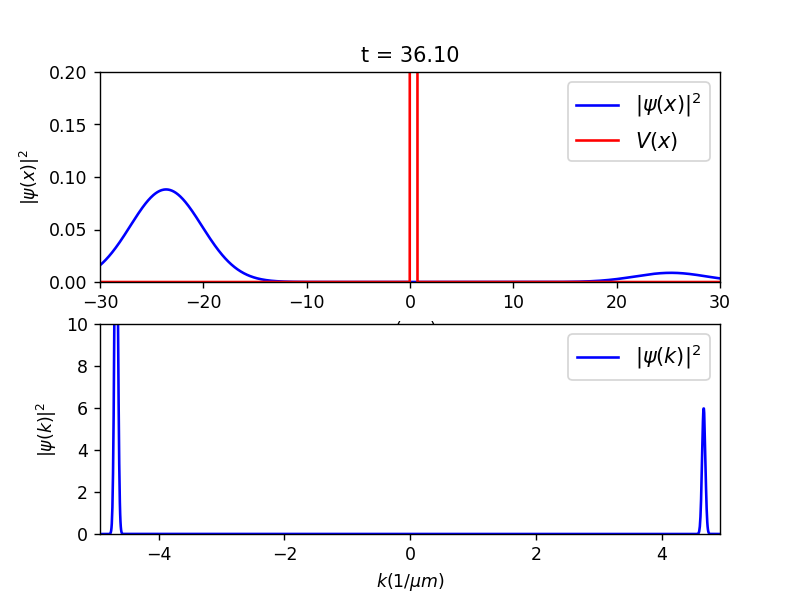

In [152]:
%matplotlib notebook
fig = plt.figure()

 
# Set up first plot for psi
ax1 = fig.add_subplot(211)
# Axes limits
ax1.set_xlim(-30,30)
ax1.set_ylim(0, 0.2)
# Label axes
ax1.set_xlabel('$x (\mu m)$')
ax1.set_ylabel('$|\psi(x)|^2$')

psi_line, = ax1.plot([],[], c = 'b', label='$|\psi(x)|^2$')
V_x_line, = ax1.plot([], [], c = 'r',label='$V(x)$')
title = ax1.set_title("")
ax1.legend(prop=dict(size=12))


# Set up second plot for momentum space
ax2 = fig.add_subplot(212)

# Setting up k axis
dk = 2*np.pi/(Nx*dx)
k_axis = np.arange(-np.pi/dx,np.pi/dx,dk) * (1/40*np.pi) # Using a scaling factor of 1/20pi for the k_axis

# Axes limits
ax2.set_xlim(min(k_axis), max(k_axis))
ax2.set_ylim(0, 10)
# Label axes
ax2.set_xlabel('$k (1/ \mu m)$')
ax2.set_ylabel('$|\psi(k)|^2$')

psi_k_line, = ax2.plot([],[], c = 'b', label='$|\psi(k)|^2$')
ax2.legend(prop=dict(size=12))



# Animate plot
def init():
    psi_line.set_data([],[])
    V_x_line.set_data([],[])
    title.set_text("")
    
    psi_k_line.set_data([],[])
    
    return psi_line, V_x_line, title, psi_k_line 

def animate(i):
    psi_line.set_data(x,9*abs(psi[i,:])**2)
    V_x_line.set_data(x,V_x)
    title.set_text("t = %.2f"%t_axis[i])
    
    psi_k_line.set_data(-k_axis,abs(psi_k[i,:])) 
    return psi_line, V_x_line, title, psi_k_line 

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=range(len(t_axis)), interval=1, blit  = True)

plt.show()